#### Script to extract tables from advice PDFs

Camelot works much better to identify the tables correctly compared to tabula, but some tweaks are needed. Especially, line_scale is required as some lines are too small for the default reader.

Problems/TODO:
1. The case when there is a range and no single value is given (e.g. advice in sol.27.4)
2. Unknown behaviour: camelot doesn't recognize some cells (e.g. before 1990 in sol.27.7d)
3. Replacement of column names looks inefficient, maybe it can be reduces with a dict

In [237]:
import os
# import tabula
import pandas as pd
import PyPDF2
import re
import camelot
import numpy as np

In [157]:
stockA = pd.read_csv("../data/stockAssesment2020/StockAssessment.csv")

C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3791297337.py:1: DtypeWarning: Columns (55,63,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  stockA = pd.read_csv("../data/stockAssesment2020/StockAssessment.csv")


In [158]:
stockA[stockA['StockDescription'].str.contains("Blue ling")].StockDescription.unique()

array(['Blue ling (Molva dypterygia) in subareas 6-7 and Division 5.b (Celtic Seas and Faroes grounds)'],
      dtype=object)

In [1031]:
fishStock = 'bss.27.4bc7ad-h' 

In [1032]:
# get page number in which Table 6 lies, and also get the next one as tables can span two oages
obj = PyPDF2.PdfFileReader("../data/pdfsICES/{}.pdf".format(fishStock))

pgno = obj.getNumPages()

#in some pdfs the Table 6 has more than one space between Table and 6
s = "Table[ ]{1,}6" 

for i in range(0, pgno):
    PgOb = obj.getPage(i)
    Text = PgOb.extractText()
    if re.search(s,Text):
         pages=str(i+1) + ',' + str(i+2)
         print(pages)

5,6


In [1033]:
# from camelot import utils
# layout, dim = utils.get_page_layout(r'C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf')

In [1034]:
# read tables with Camelot. Using backend="poppler" as Ghostscript is not working for me
# table_area is not providing the expected results
# iterations had no effect for me
tables = camelot.read_pdf("../data/pdfsICES/{}.pdf".format(fishStock), 
                           pages=pages, 
                           backend="poppler", 
                           # flavor='stream',
                           # # table_areas accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2)
                           # table_area=['0,600,590,700'],
                           # iterations=1,
                           line_scale=30,
                           # split_text=True,
                           strip_text=['#','^','<', '-', '≤', '***', '\n'],
                          )
print("Total tables extracted:", tables.n)

Total tables extracted: 8


In [1035]:
# delete tables before the first table in list that corresponds to table 6 (Advice) 
firstAdvice = [i for i, elem in enumerate(tables) if 'ICES advice' in tables[i].df.iloc[0,:].to_list()][0]
tables = tables[firstAdvice:]

In [1057]:
# filter tables by two conditions:
# [0][0] is numeric and len(columns) is equal to the len(first table 6) 
# or the first row is equal to the first row of the first table 6

filterTableSix = [i for i, elem in enumerate(tables) if (pd.to_numeric\
    (tables[i].df[0].str.extract('(\d+)')[0][0], errors='coerce') > 0\
    and len(tables[i].df.columns) == len(tables[0].df.columns))\
    or tables[i].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True
]

tableSix = [tables[i].df for i in filterTableSix]
tableSix = pd.concat(tableSix).reset_index(drop=True)

In [1145]:
# fix table 
icesTable = tableSix.copy()
icesTable.columns = icesTable.iloc[0,:]
icesTable = icesTable[1:].reset_index(drop=True)
icesTable['fishStock'] = fishStock
# sometimes the columns Year and ICES advice (text) don't split, we strip the text
icesTable['Year'] = icesTable['Year'].str.extract('(\d+)', expand=False)
icesTable = icesTable[icesTable['Year'].astype(str).str.isnumeric()]

# sometimes there is more than one space between the words in the columns
icesTable.rename(columns=lambda x: re.sub(r'[^a-zA-Z]+', ' ', x).strip(), inplace=True)

# change column names based on patter as some pdfs have different column names
for i in range(len(icesTable.columns.to_list())):
    if re.search('(?=.*[Cc]atch)(?=.*[Aa]dvice)', icesTable.columns[i]):
        icesTable.rename(columns = {icesTable.columns[i]:'SAD'}, inplace = True)
    elif re.search('(?=.*[Ll]anding)(?=.*[Aa]dvice)', icesTable.columns[i]):
        icesTable.rename(columns = {icesTable.columns[i]:'SAD_landing'}, inplace = True)
    elif re.search('(?=.*TAC)', icesTable.columns[i]):
        icesTable.rename(columns = {icesTable.columns[i]:'TAC'}, inplace = True)
    elif re.search('(?=.*ICES)(?=.*[Ll]anding)', icesTable.columns[i]):
        icesTable.rename(columns = {icesTable.columns[i]:'Landings'}, inplace = True)
    elif re.search('(?=.*ICES)(?=.*[Cc]atch)', icesTable.columns[i]):
        icesTable.rename(columns = {icesTable.columns[i]:'Catches (stockass)'}, inplace = True)
    else:
        icesTable.columns[i] == icesTable.columns[i]

# apply numeric transformation with conditional as pdfs have different columns
numericCol = ['SAD', 'SAD_landings', 'TAC', 'Landings', 'Year', 'Catches (stockass)']
for col in icesTable.columns:
    if col in numericCol:
        # strip spaces between numbers
        icesTable[col] = icesTable[col].replace({' ': ''}, regex=True)
        # for cases in which there is an explanation of the number, we strip it
        icesTable[col] = icesTable[col].str.split('(').str[0]
        icesTable[col] = icesTable[col].apply(pd.to_numeric, errors='coerce')

icesTable

,Year,ICES advice,SAD,Official commercial landings,Landings,ICES commercial discards,ICES recreational removals,fishStock
0,2000,,NaN,2100,2407.0,,,bss.27.4bc7ad-h
1,2001,,NaN,2200,2500.0,,,bss.27.4bc7ad-h
2,2002,No increase in effort or F,NaN,2400,2622.0,17,,bss.27.4bc7ad-h
3,2003,No increase in effort or F,NaN,2900,3459.0,16,,bss.27.4bc7ad-h
4,2004,No increase in effort or F,NaN,3000,3731.0,59,,bss.27.4bc7ad-h
5,2005,,NaN,3200,4430.0,96,,bss.27.4bc7ad-h
6,2006,,NaN,3396,4377.0,53,,bss.27.4bc7ad-h
7,2007,,NaN,3521,4064.0,50,,bss.27.4bc7ad-h
8,2008,,NaN,3027,4107.0,8,,bss.27.4bc7ad-h
9,2009,,NaN,4288,3889.0,151,,bss.27.4bc7ad-h


In [1174]:
checkYear = pd.Series(np.arange(icesTable.Year.iloc[0], icesTable.Year.iloc[-1]+1))

print('Year',checkYear[~checkYear.isin(icesTable.Year)].to_list(), 'was not read correctly')

Year [2015] was not read correctly


In [1173]:
for value in range(len(icesTable['SAD']))[1:-1]:
        if np.isnan(icesTable['SAD'][value])\
        and ~np.isnan(icesTable['SAD'][value-1])\
        and ~np.isnan(icesTable['SAD'][value+1]): 
            print('Year(s)', icesTable['Year'][value], 'is a special case')

Year(s) 2020 is a special case


In [1038]:
# add columns from excel and reorganize
excelTable = (icesTable.reindex(['fishStock', 'Most recent assessment with corresponding report',
 'Year','Catches (stockass)', 'SAD','TAC', 'Catches (pdfs)','done?', 'report','Landings','SAD_landings'], axis=1))
    
# icesTable = icesTable.replace('','N/A')
excelTable.set_index('fishStock', inplace=True)
excelTable.to_csv("../dataTemp/icesAdvice/{}.csv".format(fishStock))
excelTable

,Most recent assessment with corresponding report,Year,Catches (stockass),SAD,TAC,Catches (pdfs),done?,report,Landings,SAD_landings
fishStock,,,,,,,,,,
bss.27.4bc7ad-h,NaN,2000,NaN,NaN,NaN,NaN,NaN,NaN,2407.0,NaN
bss.27.4bc7ad-h,NaN,2001,NaN,NaN,NaN,NaN,NaN,NaN,2500.0,NaN
bss.27.4bc7ad-h,NaN,2002,NaN,NaN,NaN,NaN,NaN,NaN,2622.0,NaN
bss.27.4bc7ad-h,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN,3459.0,NaN
bss.27.4bc7ad-h,NaN,2004,NaN,NaN,NaN,NaN,NaN,NaN,3731.0,NaN
bss.27.4bc7ad-h,NaN,2005,NaN,NaN,NaN,NaN,NaN,NaN,4430.0,NaN
bss.27.4bc7ad-h,NaN,2006,NaN,NaN,NaN,NaN,NaN,NaN,4377.0,NaN
bss.27.4bc7ad-h,NaN,2007,NaN,NaN,NaN,NaN,NaN,NaN,4064.0,NaN
bss.27.4bc7ad-h,NaN,2008,NaN,NaN,NaN,NaN,NaN,NaN,4107.0,NaN


C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3259206825.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='text').show()


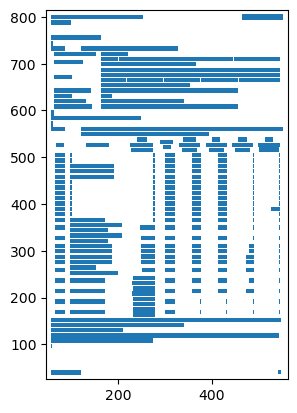

In [940]:
camelot.plot(tables[0], kind='text').show()

#### Trash

In [ ]:
# if len(tables) > 1:
#     # if table in same page is divided in two, then concatenate
#     if pd.to_numeric(tables[1].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     # if table is divided in two pages, then concatenate
#     elif tables[1].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     else:
#         tableSix = tables[0].df
# if len(tables) > 2:
#     # if table is divided in two pages, then concatenate
#     if tables[2].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tableSix, tables[2].df])
#     elif pd.to_numeric(tables[2].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tableSix, tables[2].df])
        
# tableSix

#### From tabula

In [162]:
# tables = tabula.read_pdf(r"C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf", multiple_tables=True, 
#                           pages=page, lattice=True, guess=True, java_options="-Dfile.encoding=UTF8")                        


In [159]:
# tabula.convert_into("file:///C:/Users/isaldiviagonzatti/OneDrive%20-%20Kiel%20Institut%20f%C3%BCr%20Weltwirtschaft/Documents/General/Ignacio/data/pdf_ices_test/bli.27.5b67.pdf", r"C:/Users/isaldiviagonzatti//Downloads/test.csv", output_format="csv", stream=True, pages='4')

In [ ]:
# i=1
# for table in tables:
#     table.columns = table.iloc[0]
#     table = table.reindex(table.index.drop(0)).reset_index(drop=True)
#     table.columns.name = None
#     #To write Excel
#     table.to_excel('output'+str(i)+'.xlsx',header=True,index=False)
#     #To write CSV
#     table.to_csv('output'+str(i)+'.csv',sep='|',header=True,index=False)
#     i=i+1